# COMP 562 - Machine Learning Final Project
## Plan

Our goal is to distinguish between tweets which are about real disasters and those which are about fake, metaphorical, or otherwise not real ones.
### Turning tweets into features

- Start with trigrams, can tune later
- Can consider bigrams, bag of words, or other n-grams
- Ignore location information, at least for now
- Almost all tweets have keywords, use as another feature
- Make sure to process "keyword" values, removing special characters

### Criteria for disaster
- Meant to track if tweets are referring to ongoing disasters
- Also includes historical events


### Training
- Train and validate our model on `train.csv` 
- Test by sending results to Kaggle

### Random forest
- Use Gini criterion for efficiency

### Neural networks
- Use multi-layer perceptron classifier
- Tweak alpha values

## Disaster tweet classification
### Important modules

In [2]:
import numpy as np
import pandas as pd
import string, re

### Importing data

In [2]:
train_df = pd.read_csv("diaster-tweets/data/train.csv")
test_df = pd.read_csv("disaster-tweets/data/test.csv")

### Finding all characters in dataset

In [4]:
def standardize_string(s):
    s = s.lower()
    s = re.sub("http://t\.co/\S+", "", s)
    return s

In [6]:
all_characters = set()

for tweet in train_df['text']:
    all_characters = all_characters.union(set(standardize_string(tweet)))

char_list = list(all_characters)
char_list.sort()
print(char_list)

['\n', ' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x89', '\x9d', '¡', '¢', '£', '¤', '¨', '©', 'ª', '«', '¬', '´', '¼', 'â', 'ã', 'å', 'ç', 'è', 'ê', 'ì', 'ï', 'ñ', 'ò', 'ó', '÷', 'û', 'ü']


### Narrowing down characters

We decided that from these characters, we would only keep letters, numbers, and a few accented characters. We also kept '#' and '@' due to their importance on Twitter.

In [7]:
included_chars = list(string.ascii_lowercase + string.digits) + ['#', '@', 'â', 'ã', 'å', 'ç', 'è', 'ê', 'ì', 'ï', 'ñ', 'ò', 'ó', 'ü', ' ']
print(included_chars)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '#', '@', 'â', 'ã', 'å', 'ç', 'è', 'ê', 'ì', 'ï', 'ñ', 'ò', 'ó', 'ü', ' ']


### Removing invalid characters
- Try both with and without removing special characters
- Consider skipping data points with bad characters

In [8]:
def remove_special_characters(s):
    for c in char_list:
        if c not in included_chars:
            s = s.replace(c, "")
    return s

def format_tweet(t):
    # Makes lowercase
    formatted_tweet = t.lower()
    # Removed links
    formatted_tweet = re.sub(" http(s|)://t\.co/\S+", "", formatted_tweet)
    formatted_tweet = re.sub("http(s|)://t\.co/\S+", "", formatted_tweet)
    # Removes any special characters, other than a-z, numbers, spaces, hashtags, and @
    formatted_tweet = remove_special_characters(formatted_tweet)
    final_tweet_array = []
    
    # Removes multiple consecutive spaces
    for i, char in enumerate(formatted_tweet):
        if i == 0:
            if char != ' ':
                final_tweet_array.append(char)
                continue
        prev_char = formatted_tweet[i-1]
        if char == ' ' and prev_char == ' ':
            continue
        final_tweet_array.append(char)
    final_tweet = "".join(final_tweet_array)
    return final_tweet

In [40]:
formatted_train_tweets = []
for i, tweet in enumerate(train_df["text"]):
    formatted_train_tweets.append(format_tweet(tweet))

formatted_test_tweets = []
for tweet in test_df["text"]:
    formatted_test_tweets.append(format_tweet(tweet))
    
test_ids = test_df['id']

### Splitting tweets into bigrams

Tweets were processed into bigram representations, which includes information about two consecutive words at a time.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bigram_vectorizer = CountVectorizer(ngram_range=(2,2))
bigram_train = bigram_vectorizer.fit_transform(formatted_train_tweets)
bigram_test = bigram_vectorizer.transform(formatted_test_tweets)

In [ ]:
# 1-gram no string formatting
# array([0.55543823, 0.50891089, 0.54221388, 0.51913133, 0.68794326])
# 1 and 2-gram, no string formatting
# array([0.46118721, 0.45027322, 0.43412527, 0.44141069, 0.61523626])
# 1-gram basic string formatting
# array([0.57556936, 0.48219736, 0.5530303 , 0.51859504, 0.68586387])
# 1 & 2-gram, basic string formatting
# array([0.5039019 , 0.41150442, 0.41241685, 0.45823928, 0.62327416])
# bigram only, basic string formatting
# array([0.24096386, 0.25725095, 0.1682243 , 0.17475728, 0.31060606])

### Random forest classifier
#### Creating the model

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_jobs=10, max_depth=None, class_weight="balanced")

Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

#### Cross-validation

In [ ]:
rf_parameters = {
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 4),
    'n_estimators': [50, 100, 500]
}

rf_cv = GridSearchCV(rf, rf_parameters, verbose=3, n_jobs=10)
rf_cv.fit(bigram_train, train_df['target'])
print(rf_cv.best_params_)

# {'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 500}
# {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1}

#### Predicting test data

As the disaster tweets dataset is from a Kaggle competition, the creators chose to not make the test labels public. As such, we have the random forest model make predictions on the test data. We then submitted this data to Kaggle to get an accuracy.

In [20]:
rf_predicted_classes = rf_cv.predict(bigram_test)
print(rf_predicted_classes)
rf_out_array = []
for i, pred_class in enumerate(rf_predicted_classes):
    rf_out_array.append([int(test_ids[i]), pred_class])

np.savetxt("disaster-tweets/rf-results.csv", rf_out_array, delimiter=',', fmt='%i')

[0 0 1 ... 1 1 1]
[CV 1/5] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.641 total time= 1.3min
[CV 5/5] END min_samples_leaf=1, min_samples_split=3, n_estimators=50;, score=0.667 total time=  35.2s
[CV 5/5] END min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.654 total time= 1.2min
[CV 4/5] END min_samples_leaf=1, min_samples_split=3, n_estimators=500;, score=0.611 total time= 5.9min
[CV 5/5] END min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.671 total time=  24.3s
[CV 5/5] END min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.671 total time=  46.4s
[CV 5/5] END min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=0.670 total time= 3.8min
[CV 2/5] END min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.630 total time=  42.6s
[CV 1/5] END min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.649 total time=  22.7s
[CV 1/5] END min_samples_leaf=2, min_samples_spli

[CV 2/5] END min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.610 total time=  36.3s
[CV 2/5] END min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.618 total time= 5.9min
[CV 2/5] END min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.621 total time=  32.6s
[CV 1/5] END min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.640 total time= 1.2min
[CV 2/5] END min_samples_leaf=1, min_samples_split=4, n_estimators=500;, score=0.619 total time= 5.6min
[CV 5/5] END min_samples_leaf=2, min_samples_split=3, n_estimators=50;, score=0.658 total time=  21.5s
[CV 3/5] END min_samples_leaf=2, min_samples_split=3, n_estimators=500;, score=0.622 total time= 3.6min
[CV 2/5] END min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=0.624 total time=  10.2s
[CV 5/5] END min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=0.665 total time=  11.8s
[CV 5/5] END min_samples_leaf=3, min_samples_split=2, n_estimators=10

### Multilayer perceptron classifier
#### Creating the model

In [35]:
from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(verbose=True, tol=.001)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Iteration 1, loss = 0.64550188
Iteration 2, loss = 0.37110657
Iteration 3, loss = 0.16113751
Iteration 4, loss = 0.09245533
Iteration 5, loss = 0.06919119
Iteration 6, loss = 0.05685333
Iteration 7, loss = 0.05051970
Iteration 8, loss = 0.04652030
Iteration 9, loss = 0.04329465
Iteration 10, loss = 0.04027972
Iteration 11, loss = 0.03963507
Iteration 12, loss = 0.03706136
Iteration 13, loss = 0.03634189
Iteration 14, loss = 0.03578973
Iteration 15, loss = 0.03438279
Iteration 16, loss = 0.03405455
Iteration 17, loss = 0.03368897
Iteration 18, loss = 0.03330628
Iteration 19, loss = 0.03267945
Iteration 20, loss = 0.03235284
Iteration 21, loss = 0.03212069
Iteration 22, loss = 0.03165786
Iteration 23, loss = 0.03103042
Iteration 24, loss = 0.03137677
Iteration 25, loss = 0.03200844
Iteration 26, loss = 0.03082211
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
{'alpha': 0.0001}
Iteration

Iteration 1, loss = 0.65722038
Iteration 2, loss = 0.43626507
Iteration 3, loss = 0.21774106
Iteration 4, loss = 0.12112475
Iteration 5, loss = 0.08493901
Iteration 6, loss = 0.06897639
Iteration 7, loss = 0.05892004
Iteration 8, loss = 0.05208061
Iteration 9, loss = 0.04809691
Iteration 10, loss = 0.04520381
Iteration 11, loss = 0.04264817
Iteration 12, loss = 0.04104417
Iteration 13, loss = 0.03928738
Iteration 14, loss = 0.03786395
Iteration 15, loss = 0.03649119
Iteration 16, loss = 0.03614867
Iteration 17, loss = 0.03583490
Iteration 18, loss = 0.03624316
Iteration 19, loss = 0.03435628
Iteration 20, loss = 0.03388058
Iteration 21, loss = 0.03388917
Iteration 22, loss = 0.03327046
Iteration 23, loss = 0.03332787
Iteration 24, loss = 0.03297975
Iteration 25, loss = 0.03287427
Iteration 26, loss = 0.03236315
Iteration 27, loss = 0.03217436
Iteration 28, loss = 0.03156761
Iteration 29, loss = 0.03180140
Iteration 30, loss = 0.03212690
Training loss did not improve more than tol=0.001

Iteration 1, loss = 0.65830580
Iteration 2, loss = 0.43244254
Iteration 3, loss = 0.21163385
Iteration 4, loss = 0.12001160
Iteration 5, loss = 0.08455803
Iteration 6, loss = 0.06679121
Iteration 7, loss = 0.05698308
Iteration 8, loss = 0.05125013
Iteration 9, loss = 0.04681886
Iteration 10, loss = 0.04464012
Iteration 11, loss = 0.04103793
Iteration 12, loss = 0.03952796
Iteration 13, loss = 0.03831575
Iteration 14, loss = 0.03781712
Iteration 15, loss = 0.03633931
Iteration 16, loss = 0.03540449
Iteration 17, loss = 0.03477819
Iteration 18, loss = 0.03486516
Iteration 19, loss = 0.03428989
Iteration 20, loss = 0.03414960
Iteration 21, loss = 0.03372396
Iteration 22, loss = 0.03367372
Iteration 23, loss = 0.03248387
Iteration 24, loss = 0.03285296
Iteration 25, loss = 0.03306433
Iteration 26, loss = 0.03244188
Iteration 27, loss = 0.03171769
Iteration 28, loss = 0.03188833
Iteration 29, loss = 0.03160686
Iteration 30, loss = 0.03152192
Iteration 31, loss = 0.03097679
Iteration 32, los

#### Cross-validation

In [ ]:
mlpc_parameters = {
    "alpha": [.0001, .001, .01, .1]
}
mlpc_cv = GridSearchCV(mlpc, mlpc_parameters, verbose=3, n_jobs=-1)
mlpc_cv.fit(bigram_train, train_df['target'])
print(mlpc_cv.best_params_)

#### Predicting test data

In [41]:
mlpc_predicted_classes = mlpc_cv.predict(bigram_test)
mlpc_out_array = []
for i, pred_class in enumerate(mlpc_predicted_classes):
    mlpc_out_array.append([int(test_ids[i]), pred_class])
    
np.savetxt("disaster-tweets/mlpc-results.csv", mlpc_out_array, delimiter=',', fmt='%i')

ValueError: X has 60424 features, but MLPClassifier is expecting 70186 features as input.

#### Retrying with tri-grams

Due to undesirable low accuracy, we tried to train a multilayer perceptron classifier again, this time with tweet data represented as tri-grams rather than bi-grams.

In [37]:
trigram_vectorizer = CountVectorizer(ngram_range=(3,3))
trigram_train = trigram_vectorizer.fit_transform(formatted_train_tweets)
trigram_test = trigram_vectorizer.transform(formatted_test_tweets)

mlpc_cv.fit(trigram_train, train_df['target'])
print(mlpc_cv.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Iteration 1, loss = 0.68355896
Iteration 2, loss = 0.48614873
Iteration 3, loss = 0.34652288
Iteration 4, loss = 0.28740941
Iteration 5, loss = 0.26029323
Iteration 6, loss = 0.24369238
Iteration 7, loss = 0.23209767
Iteration 8, loss = 0.22412241
Iteration 9, loss = 0.21758061
Iteration 10, loss = 0.21094973
Iteration 11, loss = 0.20776511
Iteration 12, loss = 0.20285762
Iteration 13, loss = 0.19865968
Iteration 14, loss = 0.19885302
Iteration 15, loss = 0.19540739
Iteration 16, loss = 0.19169593
Iteration 17, loss = 0.18792039
Iteration 18, loss = 0.18964934
Iteration 19, loss = 0.18932816
Iteration 20, loss = 0.18457252
Iteration 21, loss = 0.18629064
Iteration 22, loss = 0.18258087
Iteration 23, loss = 0.18106847
Iteration 24, loss = 0.18118651
Iteration 25, loss = 0.17810902
Iteration 26, loss = 0.17847097
Iteration 27, loss = 0.17870419
Iteration 28, loss = 0.17757657
Iteration 29, loss = 0.17859157
Iteration 30, loss = 

Iteration 1, loss = 0.67355953
Iteration 2, loss = 0.46689167
Iteration 3, loss = 0.25456639
Iteration 4, loss = 0.13501289
Iteration 5, loss = 0.08953687
Iteration 6, loss = 0.06925091
Iteration 7, loss = 0.05791273
Iteration 8, loss = 0.05116710
Iteration 9, loss = 0.04598761
Iteration 10, loss = 0.04309239
Iteration 11, loss = 0.04081037
Iteration 12, loss = 0.03901257
Iteration 13, loss = 0.03775687
Iteration 14, loss = 0.03629759
Iteration 15, loss = 0.03508685
Iteration 16, loss = 0.03425316
Iteration 17, loss = 0.03284821
Iteration 18, loss = 0.03307943
Iteration 19, loss = 0.03316874
Iteration 20, loss = 0.03216909
Iteration 21, loss = 0.03144714
Iteration 22, loss = 0.03136626
Iteration 23, loss = 0.03114611
Iteration 24, loss = 0.03084622
Iteration 25, loss = 0.03143071
Iteration 26, loss = 0.03024149
Iteration 27, loss = 0.02988824
Iteration 28, loss = 0.03015446
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
[CV 4/5] END ..........

Iteration 1, loss = 0.66149006
Iteration 2, loss = 0.44871846
Iteration 3, loss = 0.21380273
Iteration 4, loss = 0.12195563
Iteration 5, loss = 0.08529489
Iteration 6, loss = 0.06863533
Iteration 7, loss = 0.05859439
Iteration 8, loss = 0.05201601
Iteration 9, loss = 0.04775615
Iteration 10, loss = 0.04470486
Iteration 11, loss = 0.04229508
Iteration 12, loss = 0.04022694
Iteration 13, loss = 0.03880612
Iteration 14, loss = 0.03775526
Iteration 15, loss = 0.03710643
Iteration 16, loss = 0.03553730
Iteration 17, loss = 0.03526422
Iteration 18, loss = 0.03436012
Iteration 19, loss = 0.03420731
Iteration 20, loss = 0.03380222
Iteration 21, loss = 0.03360938
Iteration 22, loss = 0.03255339
Iteration 23, loss = 0.03368861
Iteration 24, loss = 0.03287095
Iteration 25, loss = 0.03275173
Iteration 26, loss = 0.03237421
Iteration 27, loss = 0.03119235
Iteration 28, loss = 0.03209477
Iteration 29, loss = 0.03129244
Iteration 30, loss = 0.03106711
Iteration 31, loss = 0.03126018
Iteration 32, los

Iteration 1, loss = 0.67501335
Iteration 2, loss = 0.47119074
Iteration 3, loss = 0.25407266
Iteration 4, loss = 0.13068693
Iteration 5, loss = 0.09074118
Iteration 6, loss = 0.07259510
Iteration 7, loss = 0.06245738
Iteration 8, loss = 0.05623104
Iteration 9, loss = 0.05159528
Iteration 10, loss = 0.04770466
Iteration 11, loss = 0.04522594
Iteration 12, loss = 0.04302965
Iteration 13, loss = 0.04242634
Iteration 14, loss = 0.04095443
Iteration 15, loss = 0.03954160
Iteration 16, loss = 0.03937467
Iteration 17, loss = 0.03868617
Iteration 18, loss = 0.03728549
Iteration 19, loss = 0.03684525
Iteration 20, loss = 0.03696367
Iteration 21, loss = 0.03665829
Iteration 22, loss = 0.03594930
Iteration 23, loss = 0.03559408
Iteration 24, loss = 0.03557445
Iteration 25, loss = 0.03494436
Iteration 26, loss = 0.03435305
Iteration 27, loss = 0.03467107
Iteration 28, loss = 0.03460492
Iteration 29, loss = 0.03435554
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. S

In [42]:
mlpc_trigram_predicted_classes = mlpc_cv.predict(trigram_test)
mlpc_trigram_out_array = []
for i, pred_class in enumerate(mlpc_trigram_predicted_classes):
    mlpc_trigram_out_array.append([int(test_ids[i]), pred_class])
    
np.savetxt("disaster-tweets/mlpc-trigam-results.csv", mlpc_trigram_out_array, delimiter=',', fmt='%i')

## Humor detection
### Important modules

In [26]:
import numpy as np
import pandas as pd

### Importing data

We decided to train on only 10 percent of the data, as there are 200,000 data points. Training on, for example, 60 percent of the data would take prohibitively long (more than 10 minutes for one fit). However, evaluation time is more reasonable than training time, so we can still test on the remaining 90 percent of the data.

In [27]:
from sklearn.model_selection import train_test_split

all_text = pd.read_csv("humor-dataset.csv")["text"]
all_humor = pd.read_csv("humor-dataset.csv")["humor"]

text_train, text_test, humor_train, humor_test = train_test_split(all_text, all_humor, train_size=.1)

### Making bi-grams

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

bigram_vectorizer = CountVectorizer(ngram_range=(2,2))
bigram_train = bigram_vectorizer.fit_transform(text_train)
bigram_test = bigram_vectorizer.transform(text_test)

### Random forest classifier
#### Making the model

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(max_depth=None, class_weight="balanced", n_jobs=8, verbose=3)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   36.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   36.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   36.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   36.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   36.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  7.4min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  7.4min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  7.5min


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 12.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 12.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 12.8min finished
[P

building tree 1 of 500building tree 2 of 500

building tree 3 of 500
building tree 4 of 500
building tree 5 of 500building tree 6 of 500building tree 7 of 500

building tree 8 of 500

building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s


building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67

[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    3.0s


building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500


[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    7.2s


building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   13.0s finished


#### Cross-validation

In [ ]:
rf_params = {
    'n_estimators': [50, 100, 500]
}

rf_cv = GridSearchCV(rf, rf_params, n_jobs=8, verbose=3)
rf_cv.fit(bigram_train, humor_train)
print(rf_cv.best_params_)
# {'n_estimators': 100}: 0.8332

#### Evaluation

The humor dataset, unlike the disaster tweets dataset, included labels for every piece of text in the dataset. As such, we are able to directly compute accuracy/F1 scores and also to plot confusion matrices.

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

def get_cm(preds):
    return confusion_matrix(humor_test, preds, labels=[False, True], normalize='all')

def plot_confusion_matrix(cm, title):
    fx = sb.heatmap(cm, annot=True, cmap='turbo')

    # labels the title and x, y axis of plot
    fx.set_title(title + '\n\n');
    fx.set_xlabel('Predicted Values')
    fx.set_ylabel('Actual Values ');

    # labels the boxes
    fx.xaxis.set_ticklabels(['False','True'])
    fx.yaxis.set_ticklabels(['False','True'])

    plt.show()

#### Confusion matrix and accuracy

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   19.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   35.0s finished


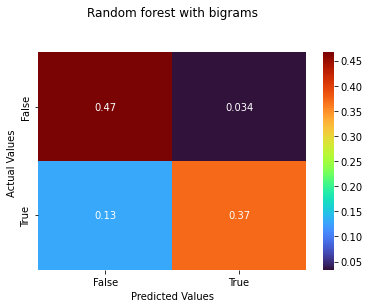

NameError: name 'rf_cv' is not defined

In [51]:
humor_preds = rf.predict(bigram_test)
rf_cm = get_cm(humor_preds)
plot_confusion_matrix(rf_cm, "Random forest with bigrams")
rf_cv.score(bigram_test, humor_test)

### Multilayer perceptron classifier
#### Making the model

In [ ]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(tol=.001, verbose=True)

#### Cross-validation

In [49]:
mlpc_params = {
    "alpha": [.0001, .001, .01, .1]
}
print("Starting CV...")
mlpc_cv = GridSearchCV(mlpc, mlpc_params, verbose=3, n_jobs=8)
mlpc_cv.fit(bigram_train, humor_train)

Starting CV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Iteration 1, loss = 0.55270584
Iteration 1, loss = 0.55314522
Iteration 1, loss = 0.54498469
Iteration 1, loss = 0.54842985
Iteration 1, loss = 0.55090679
Iteration 1, loss = 0.54417146
Iteration 1, loss = 0.54949766
Iteration 1, loss = 0.54595447
Iteration 2, loss = 0.13707193
Iteration 2, loss = 0.14322471
Iteration 2, loss = 0.15014362
Iteration 2, loss = 0.14126301
Iteration 2, loss = 0.14208745
Iteration 2, loss = 0.14655035
Iteration 2, loss = 0.14494800
Iteration 2, loss = 0.14528933
Iteration 3, loss = 0.03362346
Iteration 3, loss = 0.02917841
Iteration 3, loss = 0.03521583
Iteration 3, loss = 0.03116114
Iteration 3, loss = 0.03070502
Iteration 3, loss = 0.03070561
Iteration 3, loss = 0.03500117
Iteration 3, loss = 0.02960893
Iteration 4, loss = 0.01250560
Iteration 4, loss = 0.01792308
Iteration 4, loss = 0.01738343
Iteration 4, loss = 0.01319112
Iteration 4, loss = 0.01304526
Iteration 4, loss = 0.0176

/Users/max/.pyenv/versions/3.10.2/envs/machine-learning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/max/.pyenv/versions/3.10.2/envs/machine-learning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/max/.pyenv/versions/3.10.2/envs/machine-learning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/max/.pyenv/versions/3.10.2/envs/machine-learning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/max/.pyenv/versions/3.10.2/envs/machine-learning/lib/python3.10/site-

[CV 1/5] END .........................alpha=0.1;, score=0.874 total time=25.4min
[CV 4/5] END .........................alpha=0.1;, score=0.851 total time=16.9min
[CV 5/5] END .........................alpha=0.1;, score=0.855 total time=16.6min
[CV 2/5] END .........................alpha=0.1;, score=0.869 total time=18.8min


KeyboardInterrupt: 

#### Confusion matrix and accuracy

In [ ]:
humor_preds = mlpc.predict(bigram_test)
mlpc_cm = get_cm(humor_preds)
plot_confusion_matrix(mlpc_cm, "Multilayer perceptron with bigrams")
mlpc_cv.score(bigram_test, humor_test)